# RKHS-SHAP on California Housing Dataset

This notebook demonstrates exact RKHS-SHAP versus Kernel SHAP on the California housing dataset using Gaussian Process regression.

## Overview
- **Dataset**: California housing (8 features)
- **Sample sizes**: 100, 500, 1000
- **Model**: ExactGPModel with RBF kernel
- **Analysis**: Kernel SHAP vs Interventional RKHS-SHAP

In [ ]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from rkhs_shap.exact_gp import ExactGPModel
from rkhs_shap.rkhs_shap_exact import RKHSSHAP

plt.style.use("default")
sns.set_palette("husl")
%matplotlib inline


warnings.filterwarnings("ignore")

# SAMPLE_SIZES = [100, 500, 1000]
SAMPLE_SIZES = [100, 250, 500, 1000]
KERNEL_SHAP_MAX_SAMPLES = 500
EXPLAIN_SIZE: int | None = 100

VAL_SAMPLE_SIZE = 500
BACKGROUND_SIZE = 100
RANDOM_STATE = 42

print(f"Sample sizes to analyze: {SAMPLE_SIZES}")

Sample sizes to analyze: [100, 250, 500, 1000]


## Load and Prepare Dataset

In [149]:
def load_scaled_dataset(n_train: int, n_val: int = VAL_SAMPLE_SIZE):
    """Load and scale California housing dataset."""
    X, y = shap.datasets.california()
    rng = np.random.default_rng(RANDOM_STATE)

    n_indices = n_train + n_val
    both_indices = rng.choice(len(X), size=n_indices, replace=False)
    train_indices = both_indices[:n_train]
    val_indices = both_indices[n_train:]

    X_train = X.iloc[train_indices].values
    y_train = y[train_indices]
    X_val = X.iloc[val_indices].values
    y_val = y[val_indices]

    feature_scaler = MinMaxScaler()
    X_train = feature_scaler.fit_transform(X_train)
    X_val = feature_scaler.transform(X_val)

    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val = target_scaler.transform(y_val.reshape(-1, 1)).flatten()

    return X_train, y_train, X_val, y_val


X_full, y_full, X_scaled, y_scaled = load_scaled_dataset(20640 - VAL_SAMPLE_SIZE)

feature_names = shap.datasets.california()[0].columns.tolist()

print(f"Full dataset shape: {X_full.shape}")
print(f"Features: {feature_names}")

Full dataset shape: (20140, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


## Training and SHAP Functions

In [150]:
from rkhs_shap.utils import calculate_additivity_mae, calculate_correlation, to_tensor


def train_gp_model(X_train: np.ndarray, y_train: np.ndarray, training_iter: int = 50):
    train_x = to_tensor(X_train)
    train_y = to_tensor(y_train)
    model = ExactGPModel(train_x, train_y)
    model.fit(training_iter=training_iter, lr=0.1)
    return model


def run_kernel_shap(model, X_background, X_explain, feature_names):
    """Run Kernel SHAP on the GP model."""
    start_time = time.time()
    explainer = shap.KernelExplainer(
        model=model.predict_mean_numpy,
        data=X_background,
        feature_names=feature_names,
    )
    explanation = explainer(X_explain)
    shap_time = time.time() - start_time

    return explanation, shap_time


def run_rkhs_shap(model, X_train, y_train, X_explain):
    """Run exact RKHS-SHAP (Interventional) on the GP model."""
    start_time = time.time()

    train_x = to_tensor(X_train)
    train_y = to_tensor(y_train)
    noise_var = model.likelihood.noise.detach().cpu().float()

    rkhs_shap = RKHSSHAP(
        X=train_x,
        y=train_y,
        kernel=model.covar_module,
        noise_var=noise_var,
        cme_reg=1e-4,
    )

    X_explain_tensor = to_tensor(X_explain)
    shap_values = rkhs_shap.fit(
        X_test=X_explain_tensor,
        method="I",  # Interventional
        sample_method="full",
    )

    shap_time = time.time() - start_time
    return shap_values, shap_time


def compute_accuracy_metrics(
    kernel_shap, rkhs_shap, model_predictions, baseline: float
):
    """Compare RKHS-SHAP and Kernel SHAP accuracy."""
    if kernel_shap is None:
        kernel_values = np.zeros_like(rkhs_shap)
    else:
        kernel_values = kernel_shap.values

    kernel_additivity_errors = calculate_additivity_mae(
        kernel_values, to_tensor(model_predictions), baseline
    )
    rkhs_additivity_errors = calculate_additivity_mae(
        rkhs_shap, to_tensor(model_predictions), baseline
    )

    correlation = calculate_correlation(kernel_values, rkhs_shap)
    mse = np.mean((kernel_values - rkhs_shap) ** 2)

    if kernel_shap is None:
        kernel_additivity_errors = [np.nan] * len(rkhs_shap)
        mse = np.nan
    return {
        "kernel_additivity_mae": np.mean(kernel_additivity_errors),
        "rkhs_additivity_mae": np.mean(rkhs_additivity_errors),
        "methods_correlation": correlation,
        "methods_mse": mse,
    }

## Main Analysis: Train Models and Compute SHAP Values

In [151]:
all_metrics = []
all_kernel_explanations = []
all_rkhs_explanations = []
all_models = []
all_scalers = []
rng = np.random.default_rng(RANDOM_STATE)

for sample_size in SAMPLE_SIZES:
    print(f"\n{'=' * 70}")
    print(f"Analyzing sample size: {sample_size}")
    print(f"{'=' * 70}")

    X_train, y_train, X_val, y_val = load_scaled_dataset(sample_size)

    print("Training GP model...")
    start_time = time.time()
    model = train_gp_model(X_train, y_train)
    all_models.append(model)
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f}s")

    y_pred = model.predict_mean_numpy(X_val)
    r2 = r2_score(y_val, y_pred)
    print(f"Model R² on validation set: {r2:.4f}")

    if EXPLAIN_SIZE is not None:
        X_explain = X_train[:EXPLAIN_SIZE]  # Explain first EXPLAIN_SIZE points
    else:
        X_explain = X_train  # Explain all points
    print(f"Explaining {X_explain.shape[0]} points")

    if sample_size > KERNEL_SHAP_MAX_SAMPLES:
        # Run Kernel SHAP
        print(
            f"Skipping Kernel SHAP for sample size {sample_size} > {KERNEL_SHAP_MAX_SAMPLES})"
        )
        kernel_explanation = None
        kernel_shap_time = np.nan
    else:
        print("Running Kernel SHAP...")
        background_indices = rng.choice(
            len(X_train), size=BACKGROUND_SIZE, replace=False
        )
        X_background = X_train[background_indices]
        print(f"KernelSHAP background size: {X_background.shape[0]}")
        kernel_explanation, kernel_shap_time = run_kernel_shap(
            model, X_background, X_explain, feature_names
        )
        print(f"Kernel SHAP time: {kernel_shap_time:.2f}s")
    all_kernel_explanations.append(kernel_explanation)

    # Run RKHS-SHAP
    print("Running RKHS-SHAP...")
    rkhs_shap_values, rkhs_shap_time = run_rkhs_shap(model, X_train, y_train, X_explain)
    print(f"RKHS-SHAP time: {rkhs_shap_time:.2f}s")
    all_rkhs_explanations.append(rkhs_shap_values)

    pred_explain = model.predict_mean_numpy(X_explain)
    baseline = model.predict_mean_numpy(X_train).mean()
    accuracy_metrics = compute_accuracy_metrics(
        kernel_explanation,
        rkhs_shap_values,
        pred_explain,
        baseline,
    )

    print(f"Model prediction baseline: {baseline:.4f}")
    print(f"Methods correlation: {accuracy_metrics['methods_correlation']:.3f}")
    print(f"Kernel additivity MAE: {accuracy_metrics['kernel_additivity_mae']:.4f}")
    print(f"RKHS additivity MAE: {accuracy_metrics['rkhs_additivity_mae']:.4f}")

    # Store metrics
    metrics = {
        "sample_size": sample_size,
        "training_time": training_time,
        "model_r2": r2,
        "kernel_shap_time": kernel_shap_time,
        "rkhs_shap_time": rkhs_shap_time,
        **accuracy_metrics,
    }
    all_metrics.append(metrics)

metrics_df = pd.DataFrame(all_metrics)
print(f"\n{'=' * 70}")
print("Analysis complete!")
print(f"{'=' * 70}")


Analyzing sample size: 100
Training GP model...
iter 1/50 - loss: 1.095 {} noise: 0.693
iter 10/50 - loss: 0.866 {} noise: 0.342
iter 20/50 - loss: 0.750 {} noise: 0.156
iter 30/50 - loss: 0.744 {} noise: 0.110
iter 40/50 - loss: 0.733 {} noise: 0.125
iter 50/50 - loss: 0.730 {} noise: 0.143
Training time: 0.08s
Model R² on validation set: 0.6696
Explaining 100 points
Running Kernel SHAP...
KernelSHAP background size: 100


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel SHAP time: 1.83s
Running RKHS-SHAP...


100%|██████████| 256/256 [00:00<00:00, 970.52it/s]


RKHS-SHAP time: 0.27s
Model prediction baseline: -0.0004
Methods correlation: 1.000
Kernel additivity MAE: 0.0000
RKHS additivity MAE: 0.0114

Analyzing sample size: 250
Training GP model...
iter 1/50 - loss: 1.080 {} noise: 0.693
iter 10/50 - loss: 0.925 {} noise: 0.347
iter 20/50 - loss: 0.901 {} noise: 0.203
iter 30/50 - loss: 0.890 {} noise: 0.237
iter 40/50 - loss: 0.891 {} noise: 0.273
iter 50/50 - loss: 0.888 {} noise: 0.244
Training time: 0.15s
Model R² on validation set: 0.7109
Explaining 100 points
Running Kernel SHAP...
KernelSHAP background size: 100


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel SHAP time: 3.18s
Running RKHS-SHAP...


100%|██████████| 256/256 [00:00<00:00, 796.19it/s]


RKHS-SHAP time: 0.33s
Model prediction baseline: 0.0001
Methods correlation: 1.000
Kernel additivity MAE: 0.0401
RKHS additivity MAE: 0.0099

Analyzing sample size: 500
Training GP model...
iter 1/50 - loss: 1.048 {} noise: 0.693
iter 10/50 - loss: 0.893 {} noise: 0.347
iter 20/50 - loss: 0.850 {} noise: 0.192
iter 30/50 - loss: 0.846 {} noise: 0.186
iter 40/50 - loss: 0.842 {} noise: 0.209
iter 50/50 - loss: 0.841 {} noise: 0.217
Training time: 0.29s
Model R² on validation set: 0.7095
Explaining 100 points
Running Kernel SHAP...
KernelSHAP background size: 100


  0%|          | 0/100 [00:00<?, ?it/s]

Kernel SHAP time: 5.26s
Running RKHS-SHAP...


100%|██████████| 256/256 [00:00<00:00, 637.62it/s]


RKHS-SHAP time: 0.41s
Model prediction baseline: 0.0001
Methods correlation: 0.999
Kernel additivity MAE: 0.0066
RKHS additivity MAE: 0.0032

Analyzing sample size: 1000
Training GP model...
iter 1/50 - loss: 1.009 {} noise: 0.693
iter 10/50 - loss: 0.833 {} noise: 0.346
iter 20/50 - loss: 0.772 {} noise: 0.183
iter 30/50 - loss: 0.775 {} noise: 0.160
iter 40/50 - loss: 0.778 {} noise: 0.146
iter 50/50 - loss: 0.793 {} noise: 0.131
Training time: 0.56s
Model R² on validation set: 0.7294
Explaining 100 points
Skipping Kernel SHAP for sample size 1000 > 500)
Running RKHS-SHAP...


100%|██████████| 256/256 [00:00<00:00, 323.28it/s]


RKHS-SHAP time: 0.80s
Model prediction baseline: -0.0019
Methods correlation: nan
Kernel additivity MAE: nan
RKHS additivity MAE: 0.4881

Analysis complete!


## Visualize Results

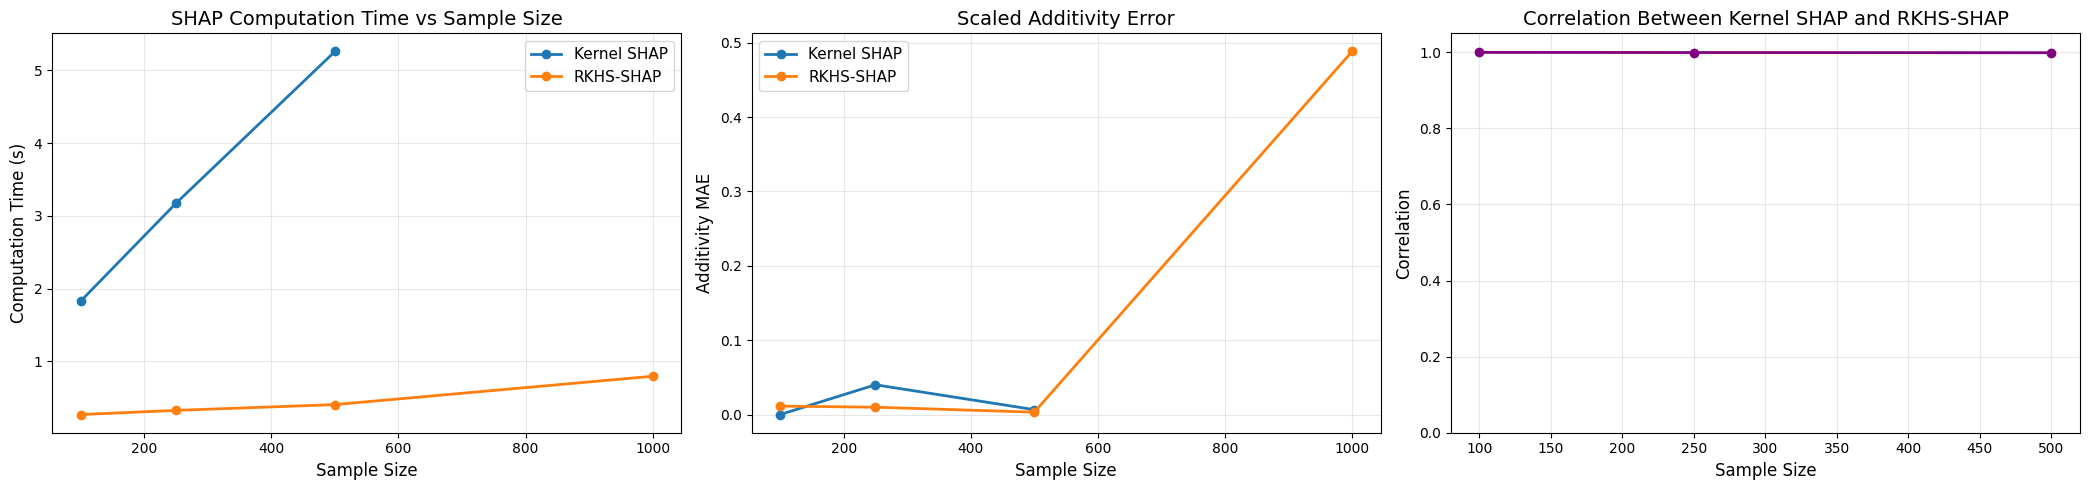


Metrics Summary:
 sample_size  training_time  model_r2  kernel_shap_time  rkhs_shap_time  kernel_additivity_mae  rkhs_additivity_mae  methods_correlation  methods_mse
         100       0.080598  0.669612          1.830485        0.270433               0.000001             0.011382             0.999833     0.000085
         250       0.146826  0.710864          3.175010        0.328005               0.040066             0.009889             0.999531     0.000194
         500       0.293489  0.709537          5.259474        0.407374               0.006605             0.003203             0.999099     0.000103
        1000       0.564892  0.729392               NaN        0.796953                    NaN             0.488120                  NaN          NaN


In [152]:
# Performance comparison plots
kernel_color = "#1f77b4"  # Blue
rkhs_color = "#ff7f0e"  # Orange

fig, axs = plt.subplots(1, 3, figsize=(21, 5))

# Computation time
axs[0].plot(
    metrics_df["sample_size"],
    metrics_df["kernel_shap_time"],
    marker="o",
    label="Kernel SHAP",
    color=kernel_color,
    linewidth=2,
)
axs[0].plot(
    metrics_df["sample_size"],
    metrics_df["rkhs_shap_time"],
    marker="o",
    label="RKHS-SHAP",
    color=rkhs_color,
    linewidth=2,
)
axs[0].set_xlabel("Sample Size", fontsize=12)
axs[0].set_ylabel("Computation Time (s)", fontsize=12)
axs[0].set_title("SHAP Computation Time vs Sample Size", fontsize=14)
axs[0].legend(fontsize=11)
axs[0].grid(True, alpha=0.3)

# Additivity error
axs[1].plot(
    metrics_df["sample_size"],
    metrics_df["kernel_additivity_mae"],
    marker="o",
    label="Kernel SHAP",
    color=kernel_color,
    linewidth=2,
)
axs[1].plot(
    metrics_df["sample_size"],
    metrics_df["rkhs_additivity_mae"],
    marker="o",
    label="RKHS-SHAP",
    color=rkhs_color,
    linewidth=2,
)
axs[1].set_xlabel("Sample Size", fontsize=12)
axs[1].set_ylabel("Additivity MAE", fontsize=12)
axs[1].set_title("Scaled Additivity Error", fontsize=14)
axs[1].legend(fontsize=11)
axs[1].grid(True, alpha=0.3)

# Correlation
axs[2].plot(
    metrics_df["sample_size"],
    metrics_df["methods_correlation"],
    marker="o",
    color="purple",
    linewidth=2,
)
axs[2].set_xlabel("Sample Size", fontsize=12)
axs[2].set_ylabel("Correlation", fontsize=12)
axs[2].set_title("Correlation Between Kernel SHAP and RKHS-SHAP", fontsize=14)
axs[2].set_ylim(0, 1.05)
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMetrics Summary:")
print(metrics_df.to_string(index=False))

## SHAP Value Comparison for Each Sample Size

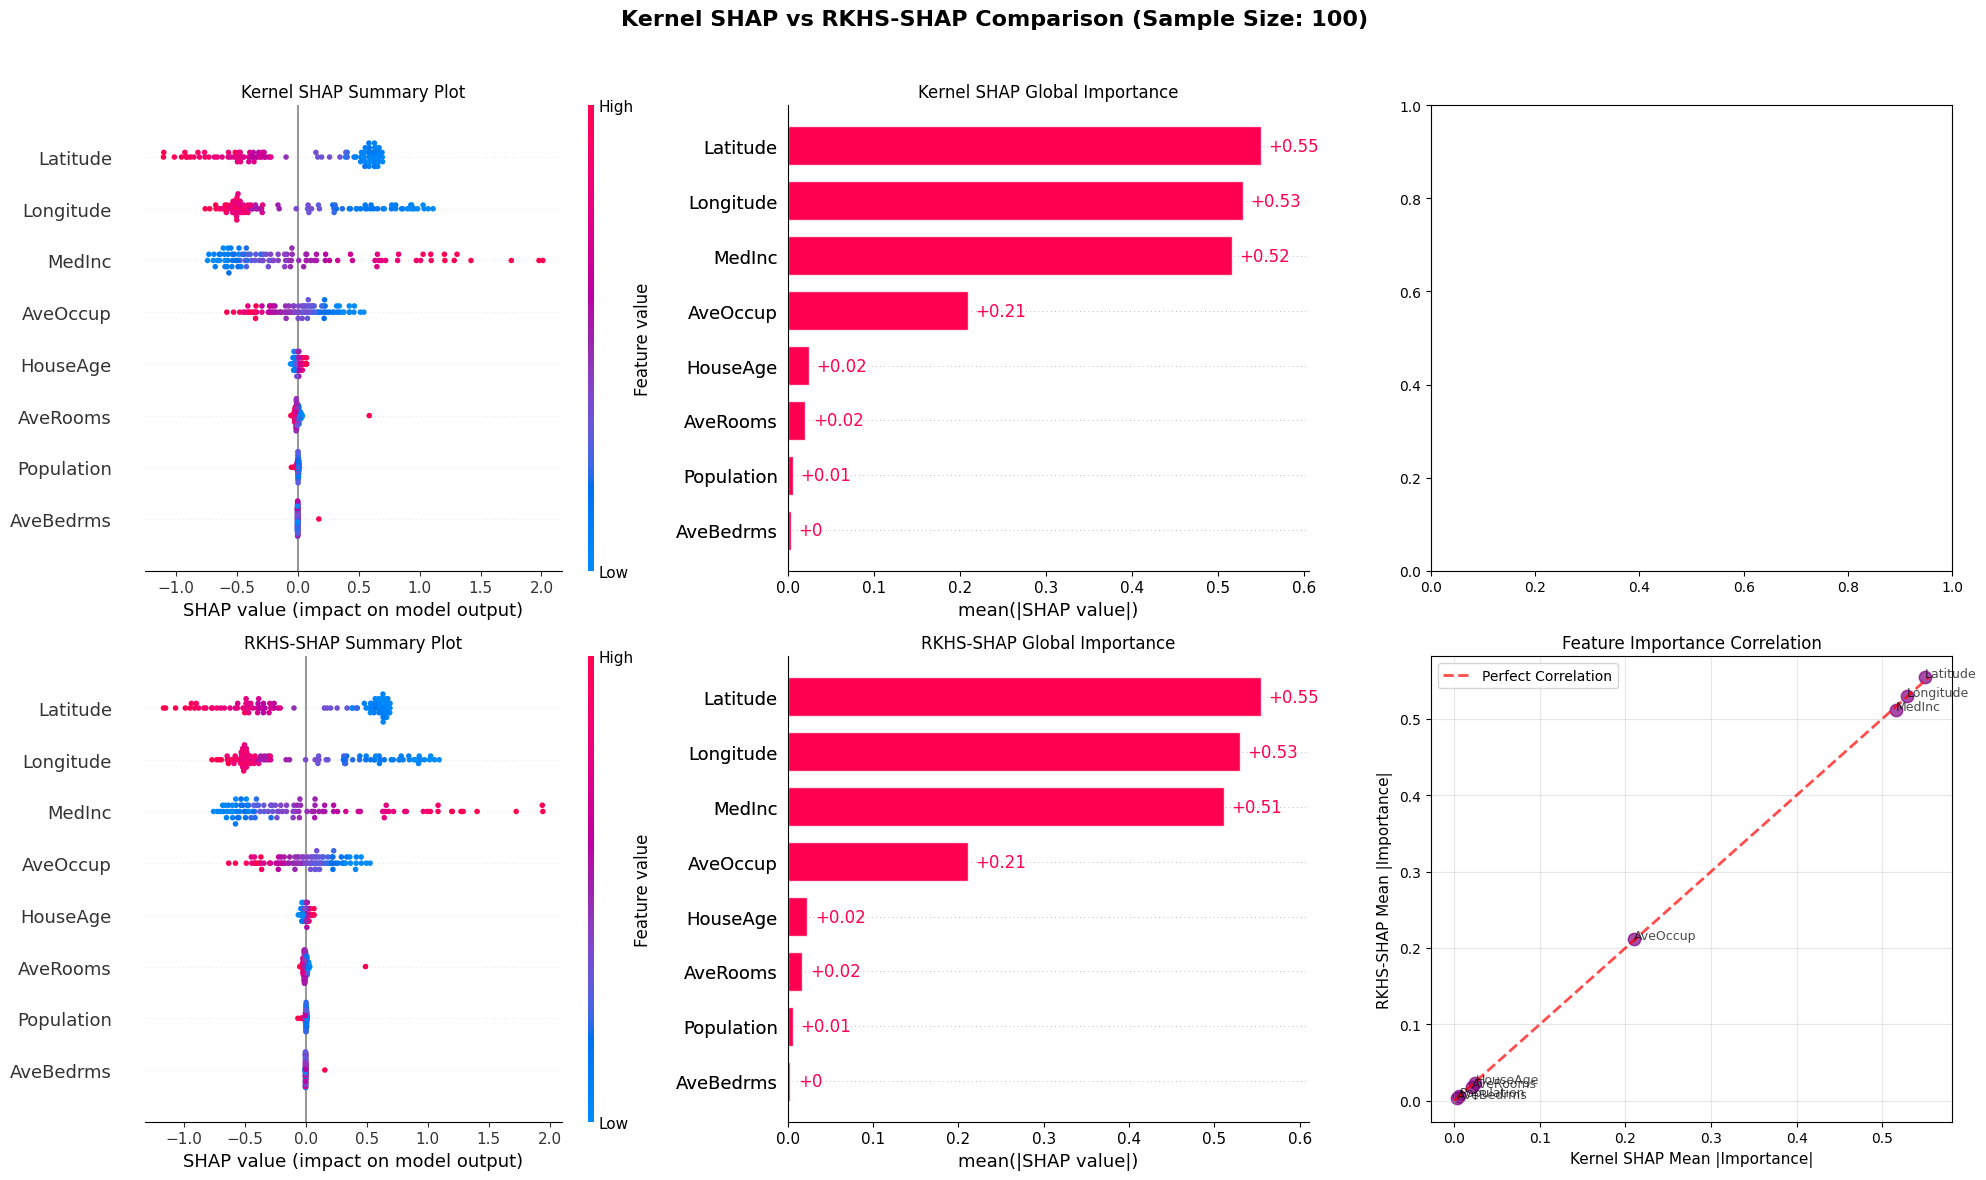

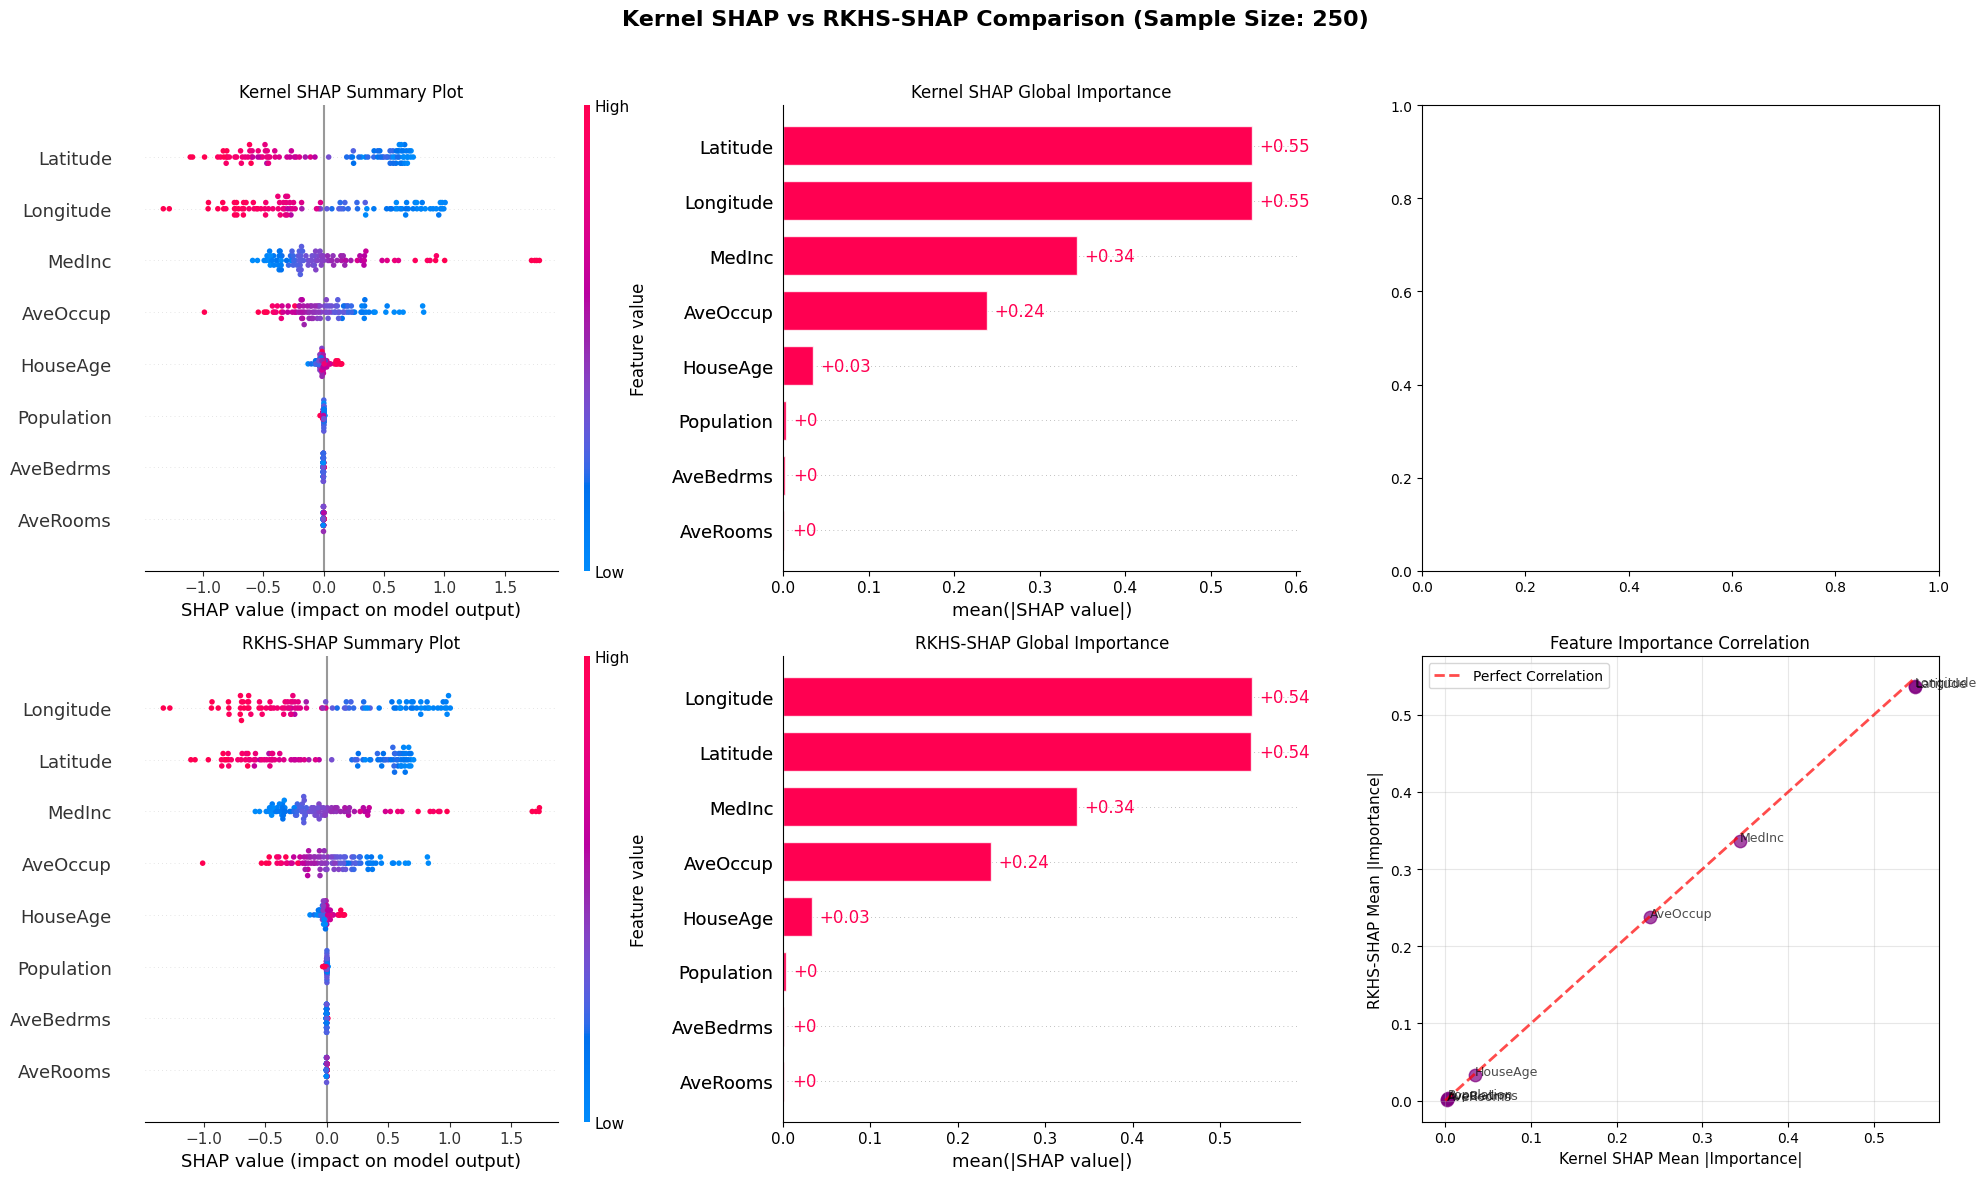

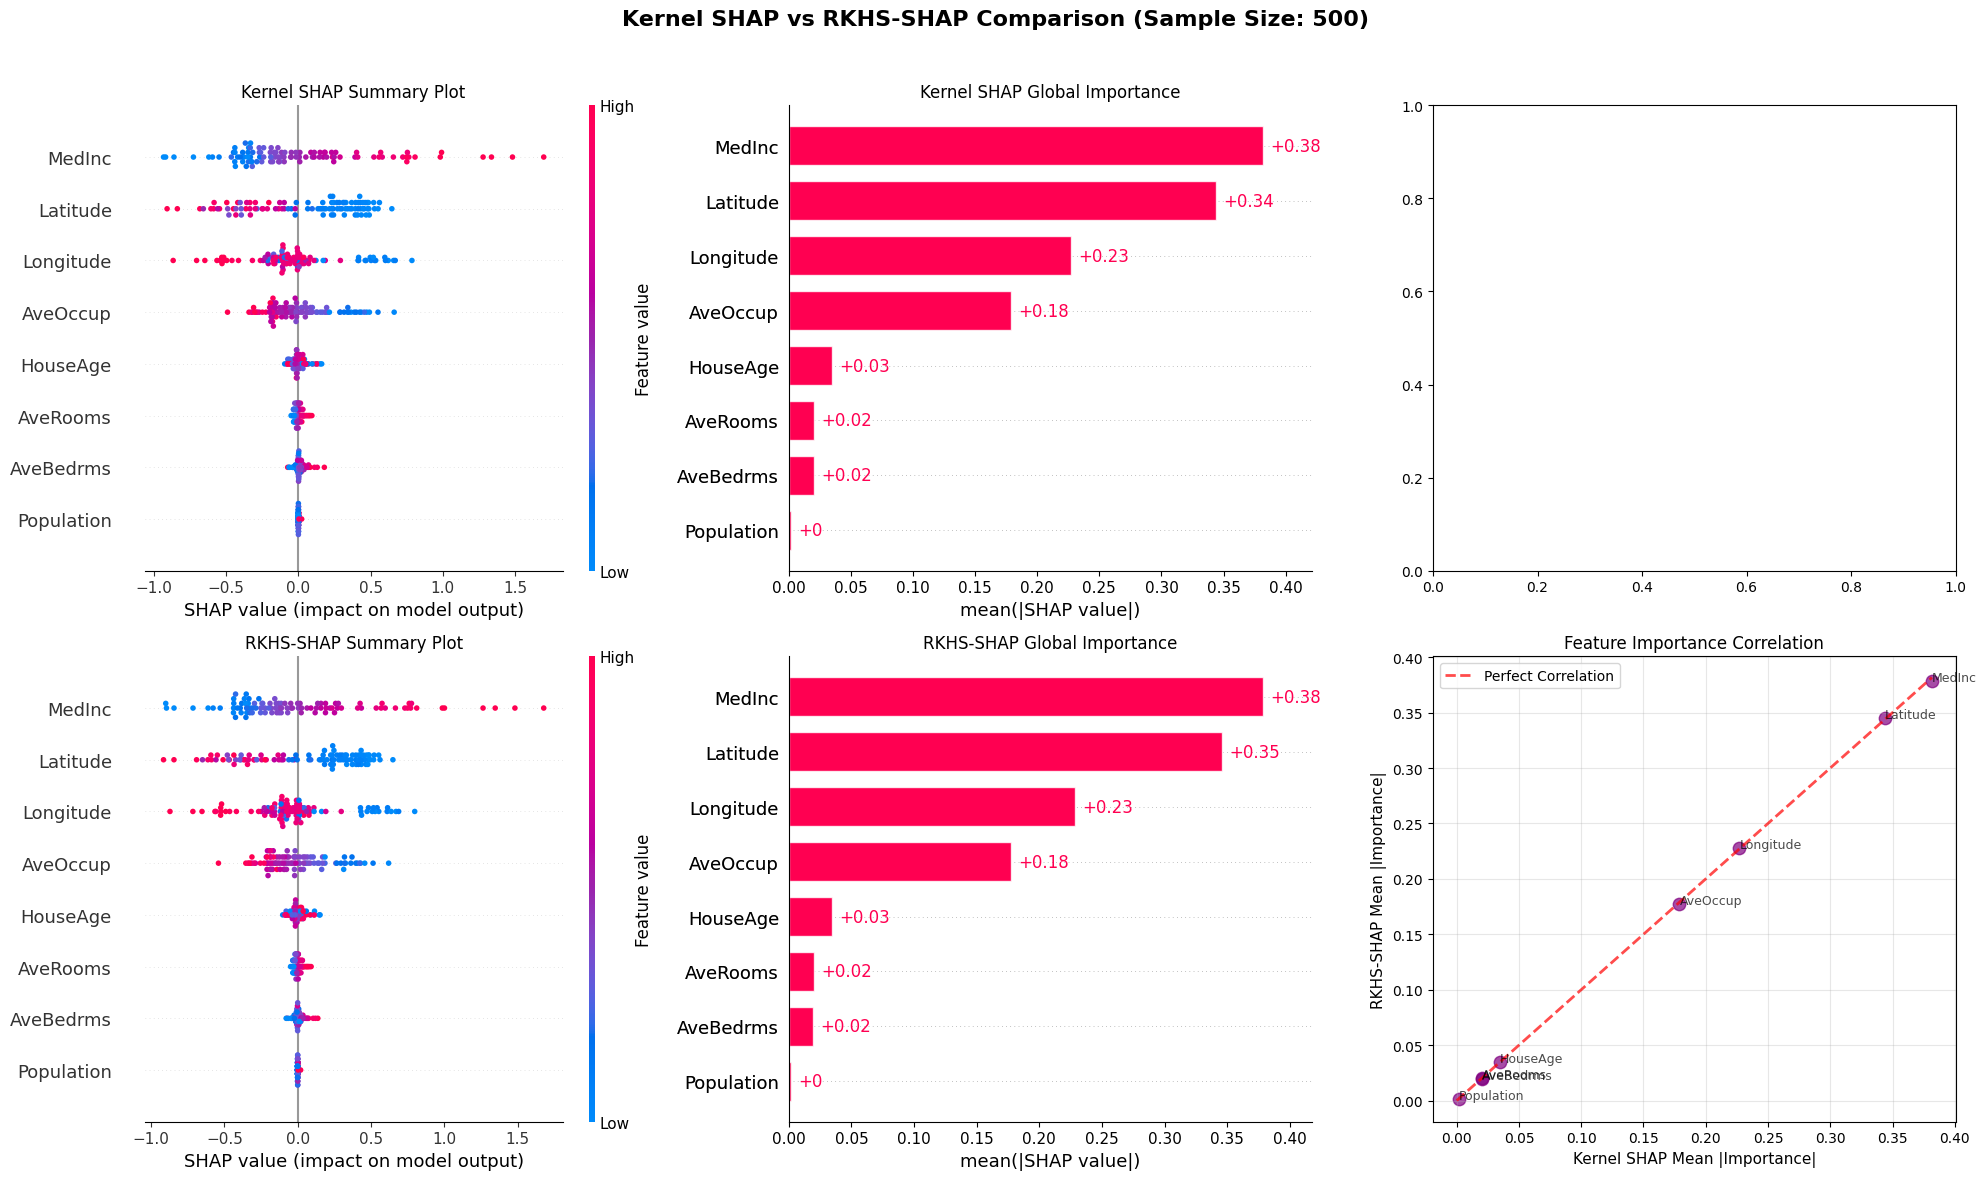

Error plotting RKHS-SHAP explanations: 'NoneType' object has no attribute 'data'


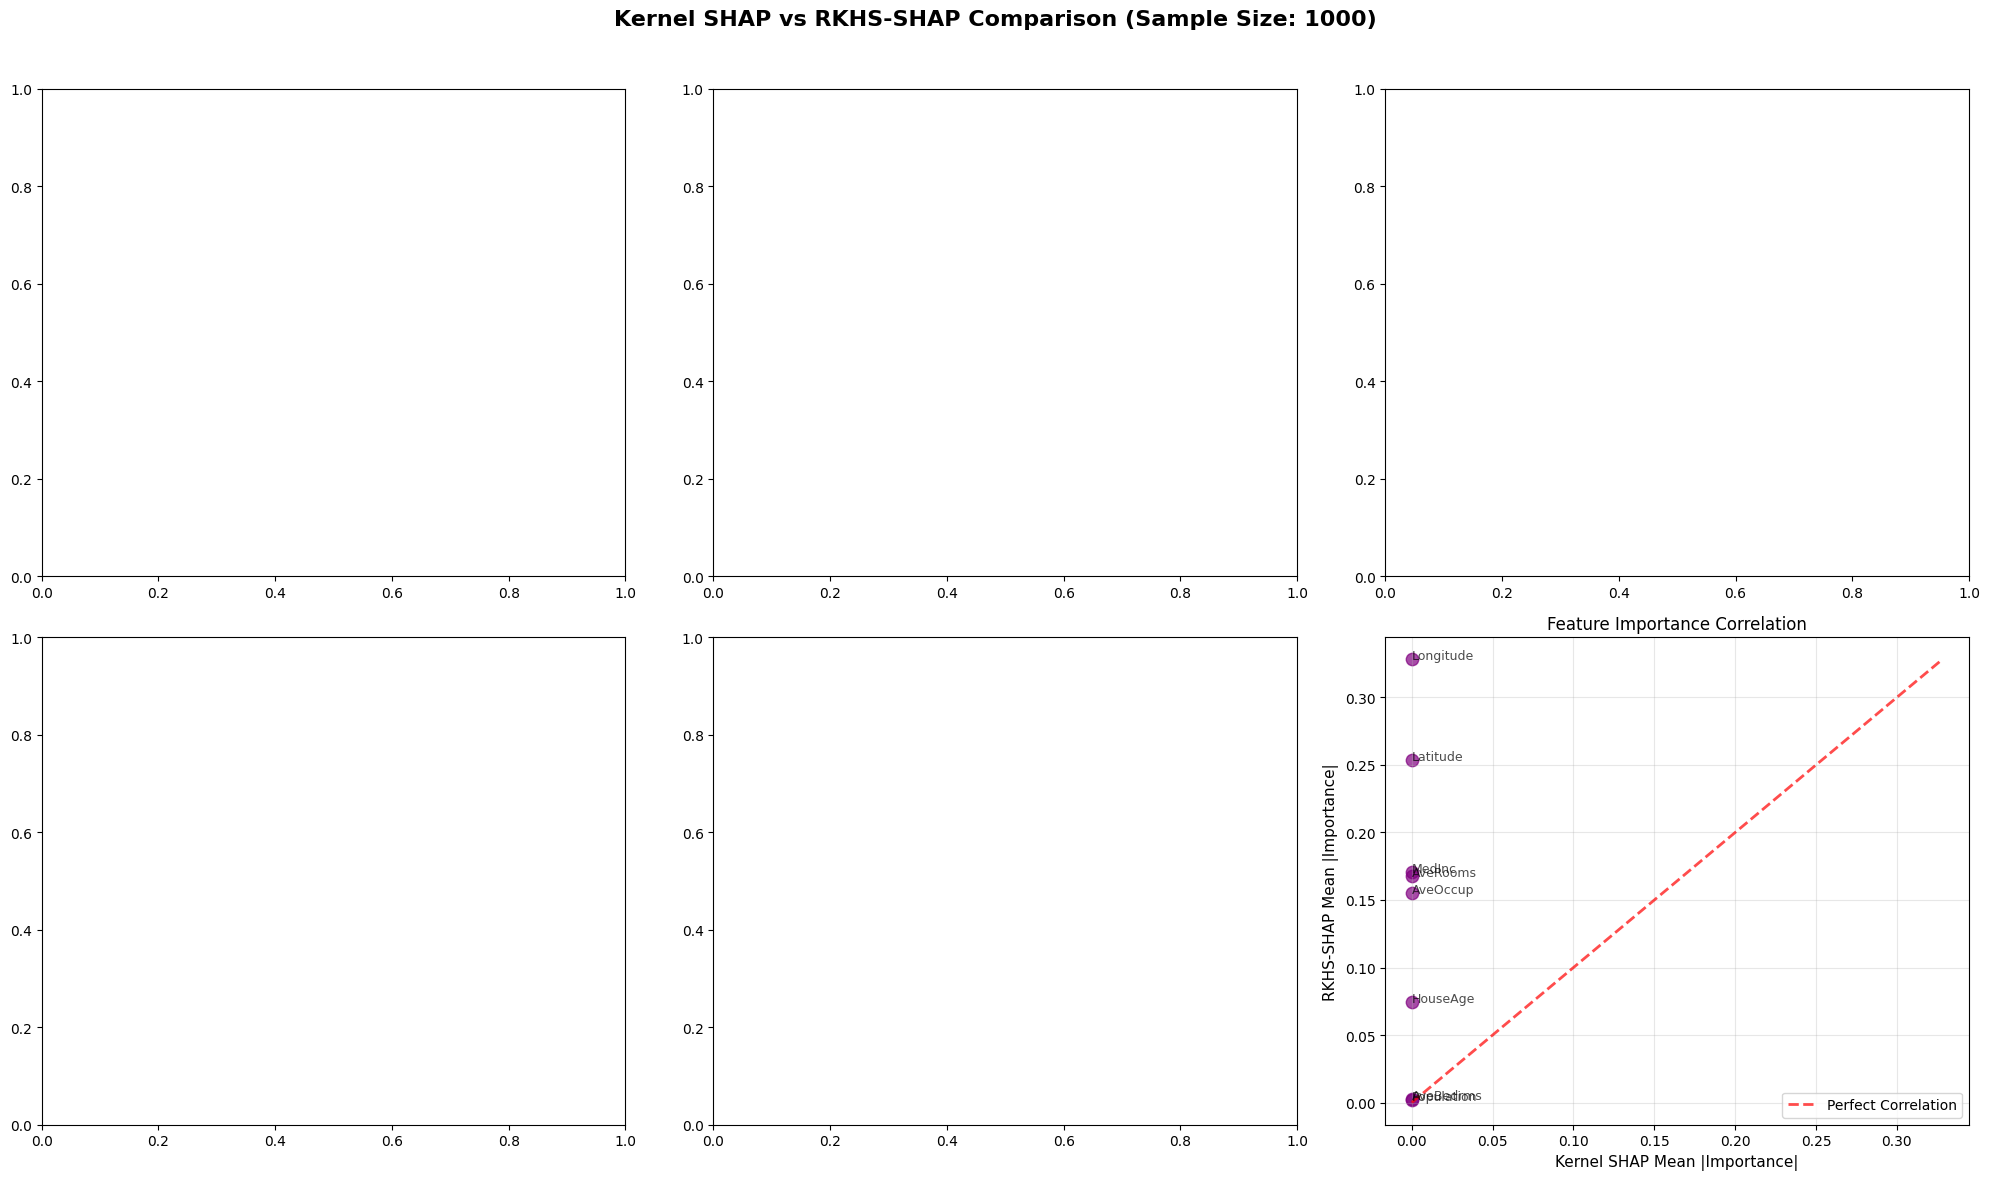

In [153]:
for i, sample_size in enumerate(SAMPLE_SIZES):
    kernel_explanation = all_kernel_explanations[i]
    rkhs_explanation = all_rkhs_explanations[i]
    model = all_models[i]

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(
        f"Kernel SHAP vs RKHS-SHAP Comparison (Sample Size: {sample_size})",
        fontsize=16,
        fontweight="bold",
    )

    # Correlation plot between methods
    rkhs_mean_abs = np.mean(np.abs(rkhs_explanation), axis=0)
    kernel_mean_abs = np.zeros_like(rkhs_mean_abs)

    # Kernel SHAP plots
    if kernel_explanation is not None:
        kernel_mean_abs = np.mean(np.abs(kernel_explanation.values), axis=0)
        shap.plots.beeswarm(
            kernel_explanation, ax=axes[0, 0], plot_size=None, show=False
        )
        axes[0, 0].set_title("Kernel SHAP Summary Plot", fontsize=12)

        shap.plots.bar(kernel_explanation, ax=axes[0, 1], show=False)
        axes[0, 1].set_title("Kernel SHAP Global Importance", fontsize=12)

    try:
        # TODO enable creating RKHS Explanation when no Kernel SHAP is present
        # RKHS-SHAP plots
        rkhs_fake_explanation = shap.Explanation(
            values=rkhs_explanation,
            data=kernel_explanation.data,
            feature_names=kernel_explanation.feature_names,
        )

        shap.plots.beeswarm(
            rkhs_fake_explanation, ax=axes[1, 0], plot_size=None, show=False
        )
        axes[1, 0].set_title("RKHS-SHAP Summary Plot", fontsize=12)
        shap.plots.bar(rkhs_fake_explanation, ax=axes[1, 1], show=False)
        axes[1, 1].set_title("RKHS-SHAP Global Importance", fontsize=12)
    except Exception as e:
        print(f"Error plotting RKHS-SHAP explanations: {e}")

    axes[1, 2].scatter(kernel_mean_abs, rkhs_mean_abs, alpha=0.7, s=80, color="purple")

    # Add feature labels
    for j, name in enumerate(feature_names):
        axes[1, 2].annotate(
            name, (kernel_mean_abs[j], rkhs_mean_abs[j]), fontsize=9, alpha=0.7
        )

    # Perfect correlation line
    max_val = max(kernel_mean_abs.max(), rkhs_mean_abs.max())
    axes[1, 2].plot(
        [0, max_val],
        [0, max_val],
        "r--",
        alpha=0.7,
        label="Perfect Correlation",
        linewidth=2,
    )

    axes[1, 2].set_xlabel("Kernel SHAP Mean |Importance|", fontsize=11)
    axes[1, 2].set_ylabel("RKHS-SHAP Mean |Importance|", fontsize=11)
    axes[1, 2].set_title("Feature Importance Correlation", fontsize=12)
    axes[1, 2].legend(fontsize=10)
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()